## Experiment option

1. Try different models: 
- LSTM/GRU Networks: The starter code already includes a simple LSTM model. This is a good starting point as temporal dependencies are important.
- Transformer-based models: Could capture long-range dependencies better than LSTMs.
- Graph Neural Networks (GNNs): Especially useful if you model the skeleton as a graph structure.

2. Bio-mechanical Constraints
- Loss function constraints: Add penalty terms to your loss function that increase when predictions violate biomechanical constraints.
- Post-processing corrections: Apply corrections to predictions that violate constraints.
- Constrained outputs: Use activation functions that limit the output range.

## Load data

In [1]:
import glob

from collections import defaultdict
import matplotlib.pyplot as plt

from preprocess import *

In [2]:
filenames = glob.glob('../data/*.npz')
assert len(filenames) > 0, 'No data files found in ./data/'

filename = filenames[1]
data = np.load(filename)
print('Data containing:')
[print(f'Array {f} of shape {data[f].shape}') for f in data.files];

Data containing:
Array time of shape (596,)
Array leftShoulderPosRel of shape (596, 3)
Array rightShoulderPosRel of shape (596, 3)
Array leftElbowPosRel of shape (596, 3)
Array rightElbowPosRel of shape (596, 3)
Array leftWristPosRel of shape (596, 3)
Array rightWristPosRel of shape (596, 3)
Array leftFingerPosRel of shape (596, 3)
Array rightFingerPosRel of shape (596, 3)
Array accelerationLeftLoc of shape (596, 3)
Array accelerationRightLoc of shape (596, 3)
Array gyroLeftLoc of shape (596, 3)
Array gyroRightLoc of shape (596, 3)


In [3]:
dt = np.diff(data['time'])
SAMPLE_RATE = 1.0 / np.mean(dt)
print('Sample rate:', SAMPLE_RATE)

Sample rate: 60.0


## Visualize data

#### Visualize MoCap

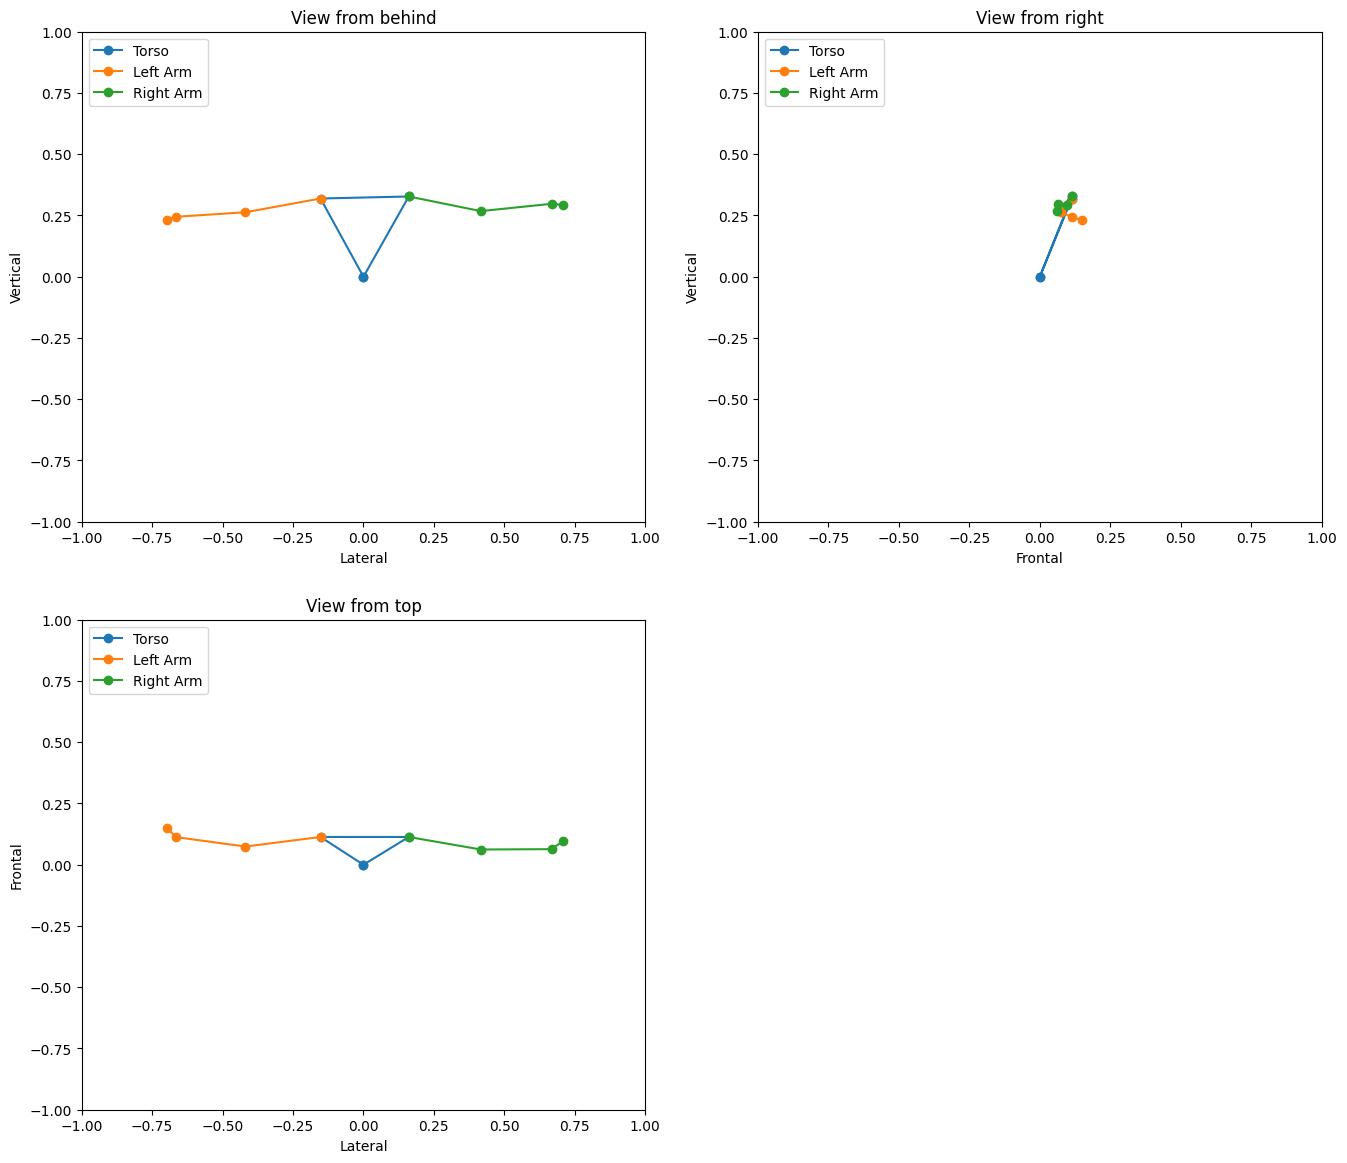

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(16,14))

t = 0 # Select frame to observe
time, torso, left_arm, right_arm = extractMoCap(data)

[ax[i,j].set_xlim(-1,1) for i in range(2) for j in range(2)]
[ax[i,j].set_ylim(-1,1) for i in range(2) for j in range(2)]

ax[0,0].set_title('View from behind')
ax[0,0].set_xlabel('Lateral')
ax[0,0].set_ylabel('Vertical')
t_00, = ax[0,0].plot(torso[t,:,0], torso[t,:,2], '-o', label='Torso')
l_00, = ax[0,0].plot(left_arm[t,:,0], left_arm[t,:,2], '-o', label='Left Arm')
r_00, = ax[0,0].plot(right_arm[t,:,0], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('View from right')
ax[0,1].set_xlabel('Frontal')
ax[0,1].set_ylabel('Vertical')
t_01, = ax[0,1].plot(torso[t,:,1], torso[t,:,2], '-o', label='Torso')
l_01, = ax[0,1].plot(left_arm[t,:,1], left_arm[t,:,2], '-o', label='Left Arm')
r_01, = ax[0,1].plot(right_arm[t,:,1], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('View from top')
ax[1,0].set_xlabel('Lateral')
ax[1,0].set_ylabel('Frontal')
t_10, = ax[1,0].plot(torso[t,:,0], torso[t,:,1], '-o', label='Torso')
l_10, = ax[1,0].plot(left_arm[t,:,0], left_arm[t,:,1], '-o', label='Left Arm')
r_10, = ax[1,0].plot(right_arm[t,:,0], right_arm[t,:,1], '-o', label='Right Arm')
ax[1,0].legend(loc='upper left')

ax[1,1].set_axis_off()

#### Visualize IMU

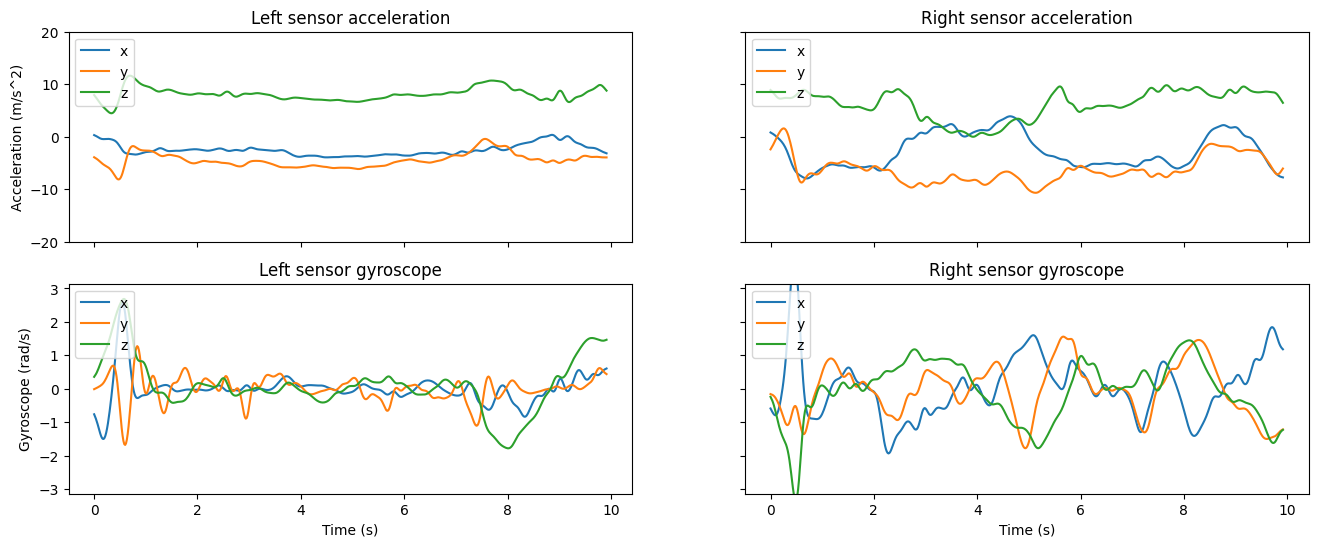

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(16,6), sharex=True, sharey='row')

time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

ax[0,0].set_ylim(-20,20)
ax[1,0].set_ylim(-np.pi,np.pi)

ax[0,0].set_title('Left sensor acceleration')
ax[0,0].set_ylabel('Acceleration (m/s^2)')
ax[0,0].plot(time, left_acc, label=['x', 'y', 'z'])
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('Right sensor acceleration')
ax[0,1].plot(time, right_acc, label=['x', 'y', 'z'])
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('Left sensor gyroscope')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Gyroscope (rad/s)')
ax[1,0].plot(time, left_gyro, label=['x', 'y', 'z'])
ax[1,0].legend(loc='upper left')

ax[1,1].set_title('Right sensor gyroscope')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].plot(time, right_gyro, label=['x', 'y', 'z'])
ax[1,1].legend(loc='upper left')

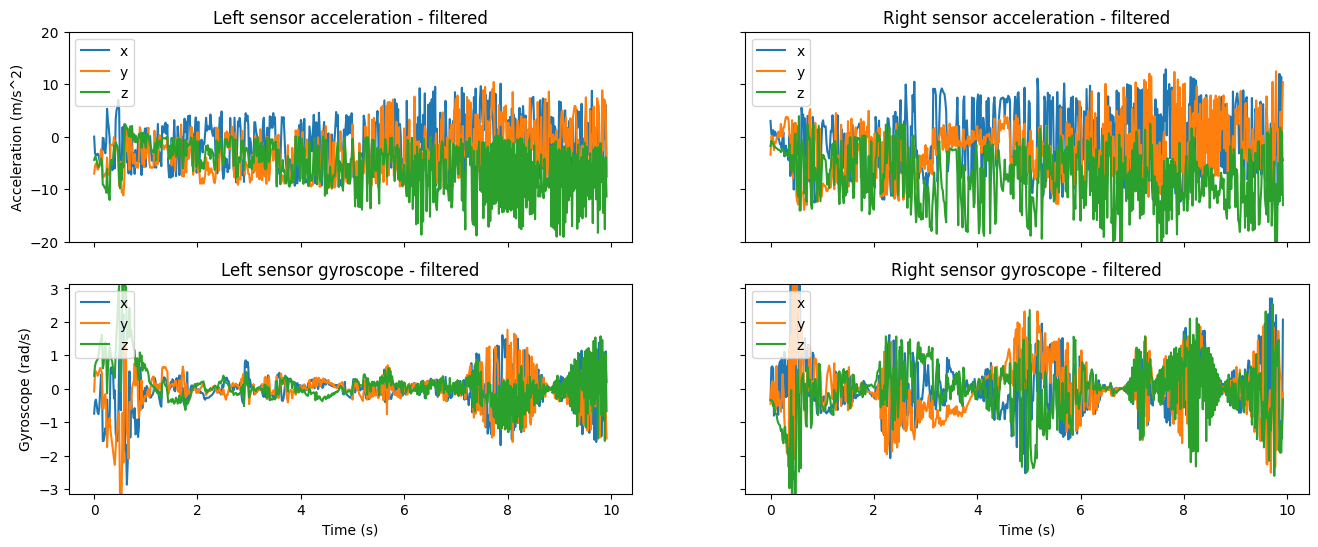

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16,6), sharex=True, sharey='row')

left_acc_filt, left_gyro_filt = vqf_filter(left_acc, left_gyro, sample_rate=SAMPLE_RATE)

right_acc_filt, right_gyro_filt = vqf_filter(right_acc, right_gyro, sample_rate=SAMPLE_RATE)

ax[0,0].set_ylim(-20,20)
ax[1,0].set_ylim(-np.pi,np.pi)

ax[0,0].set_title('Left sensor acceleration - filtered')
ax[0,0].set_ylabel('Acceleration (m/s^2)')
ax[0,0].plot(time, left_acc_filt, label=['x', 'y', 'z'])
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('Right sensor acceleration - filtered')
ax[0,1].plot(time, right_acc_filt, label=['x', 'y', 'z'])
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('Left sensor gyroscope - filtered')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Gyroscope (rad/s)')
ax[1,0].plot(time, left_gyro_filt, label=['x', 'y', 'z'])
ax[1,0].legend(loc='upper left')

ax[1,1].set_title('Right sensor gyroscope - filtered')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].plot(time, right_gyro_filt, label=['x', 'y', 'z'])
ax[1,1].legend(loc='upper left')

/home/patrick-do/Documents/Projects/CS690R_Project/cs690r/venv/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1024 is greater than input length  = 596, using nperseg = 596
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


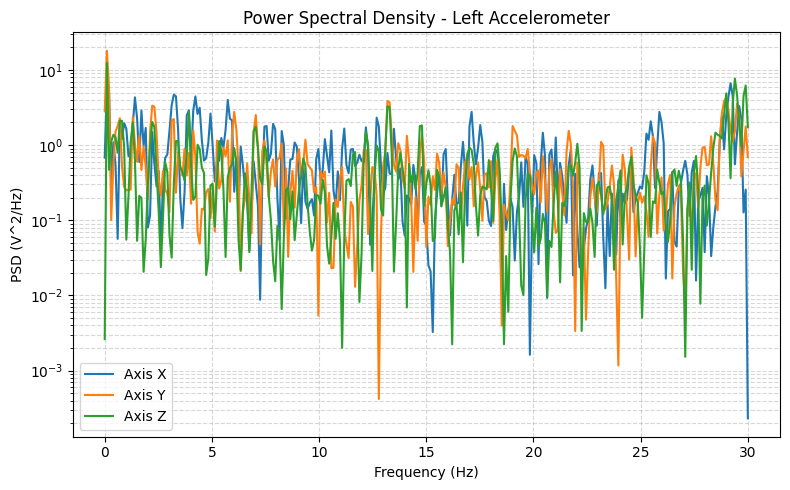

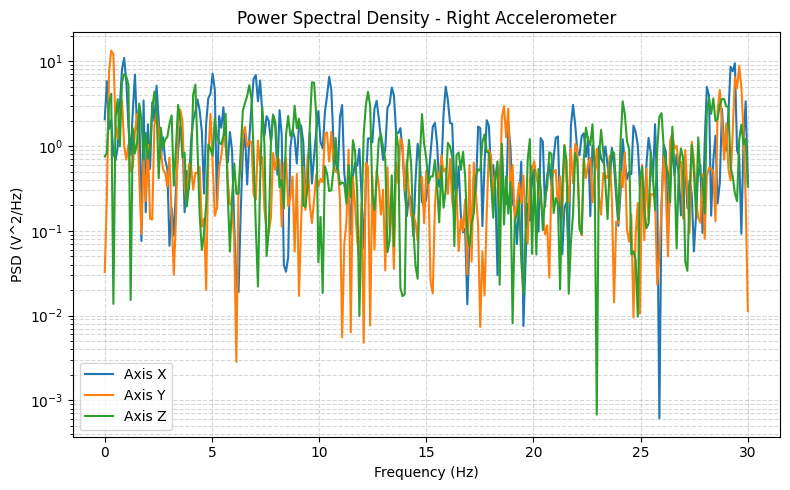

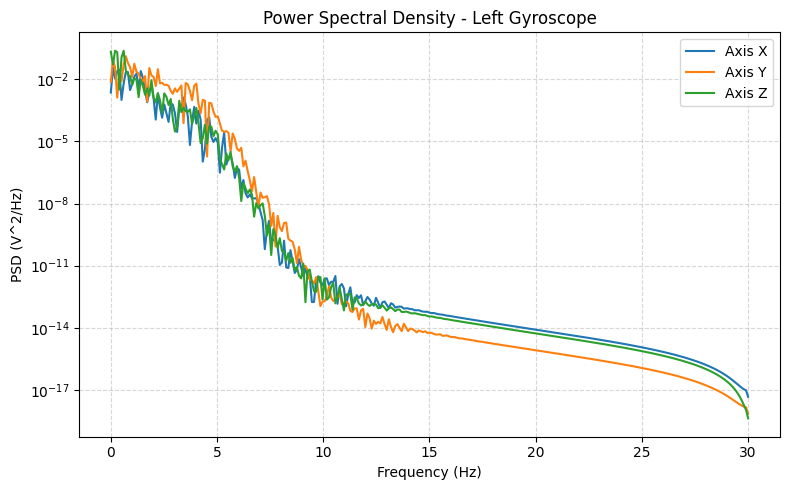

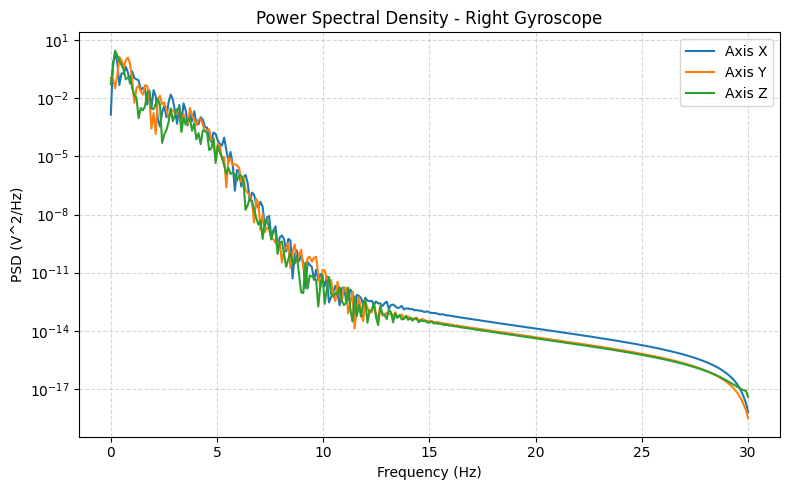

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_imu_psd(raw_imu_signals, sample_rate=60.0, sensor_label='IMU Sensor'):
    """
    Plot Power Spectral Density (PSD) for each axis of IMU signals.

    Args:
        raw_imu_signals: np.ndarray of shape (T, 3), where T is timesteps and 3 axes.
        sample_rate: Sampling frequency in Hz.
        sensor_label: Label for the sensor (e.g., 'Left Accelerometer').
    """
    # Compute PSD using Welch's method
    f, Pxx = welch(raw_imu_signals, fs=sample_rate, axis=0, nperseg=1024)

    # Plot each axis on the same figure
    plt.figure(figsize=(8, 5))
    plt.semilogy(f, Pxx[:, 0], label='Axis X')
    plt.semilogy(f, Pxx[:, 1], label='Axis Y')
    plt.semilogy(f, Pxx[:, 2], label='Axis Z')
    
    plt.title(f'Power Spectral Density - {sensor_label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V^2/Hz)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming left_acc, right_acc, left_gyro, right_gyro are numpy arrays (T,3)
# and sample_rate is defined
plot_imu_psd(left_acc_filt, sample_rate=60.0, sensor_label='Left Accelerometer')
plot_imu_psd(right_acc_filt, sample_rate=60.0, sensor_label='Right Accelerometer')
plot_imu_psd(left_gyro, sample_rate=60.0, sensor_label='Left Gyroscope')
plot_imu_psd(right_gyro, sample_rate=60.0, sensor_label='Right Gyroscope')


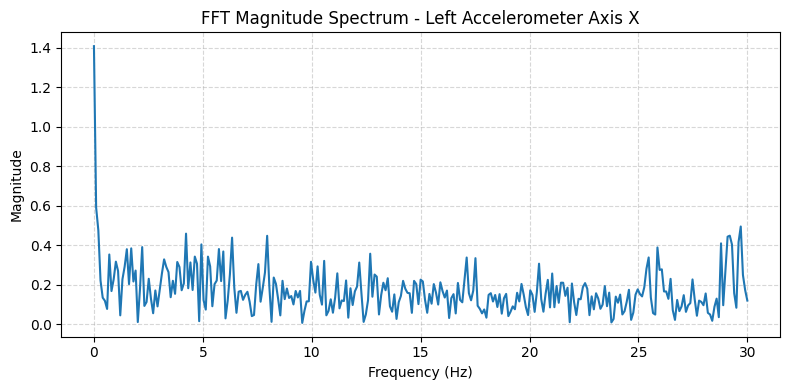

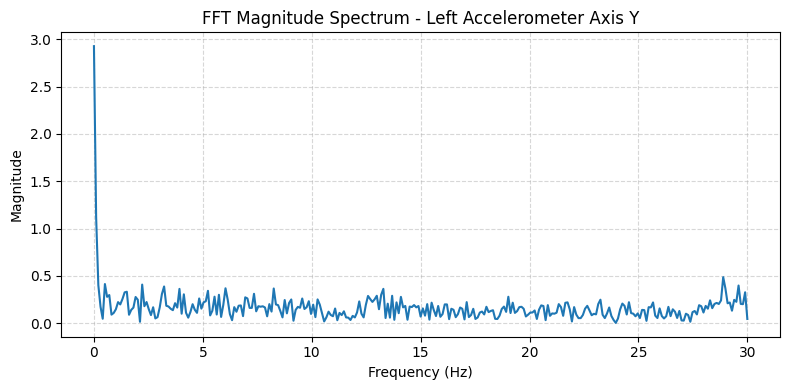

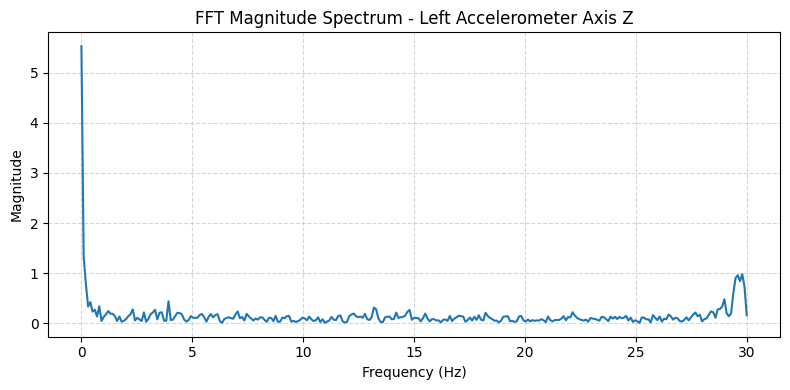

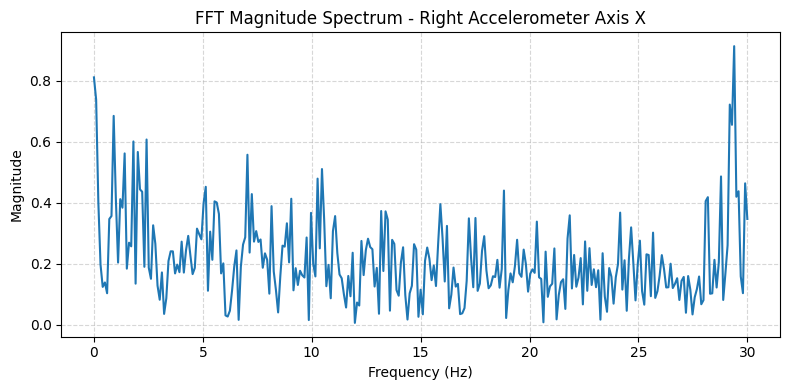

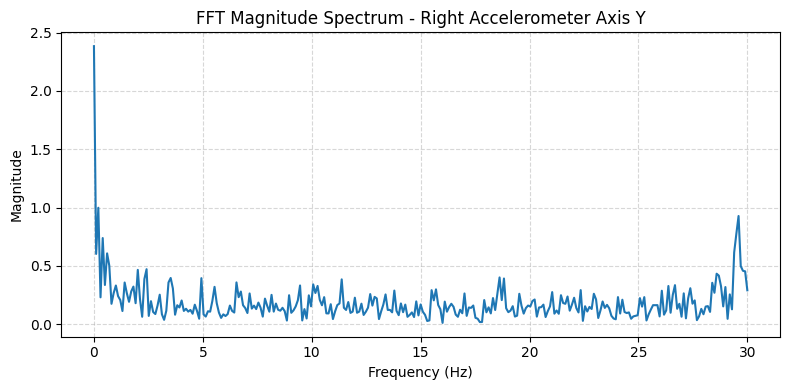

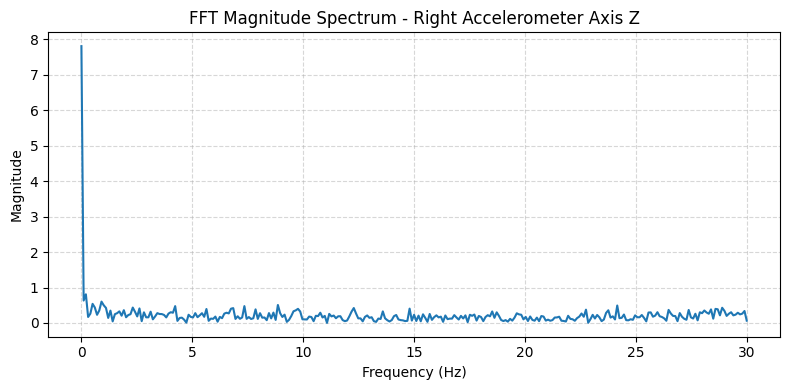

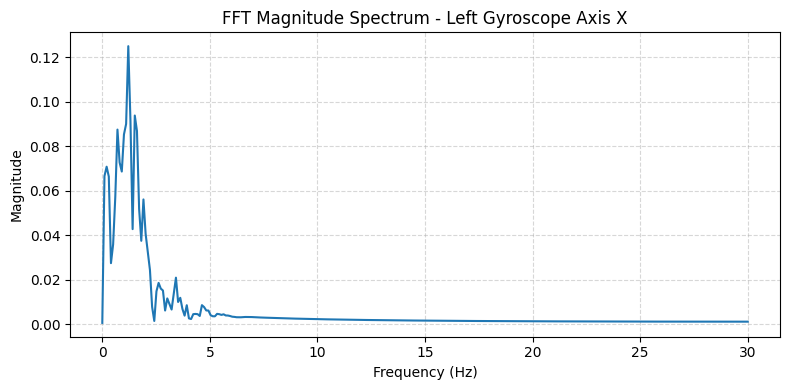

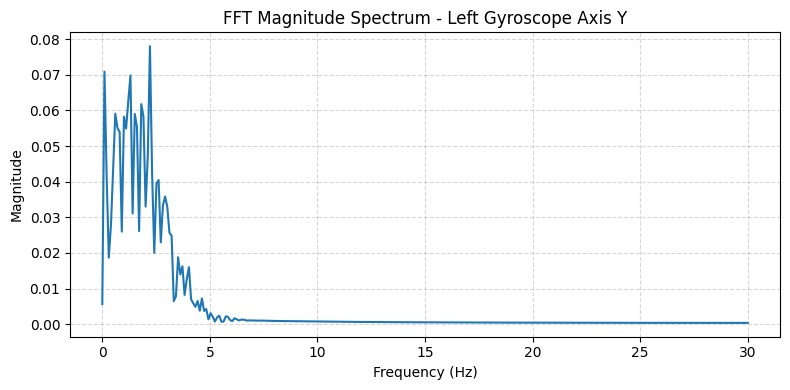

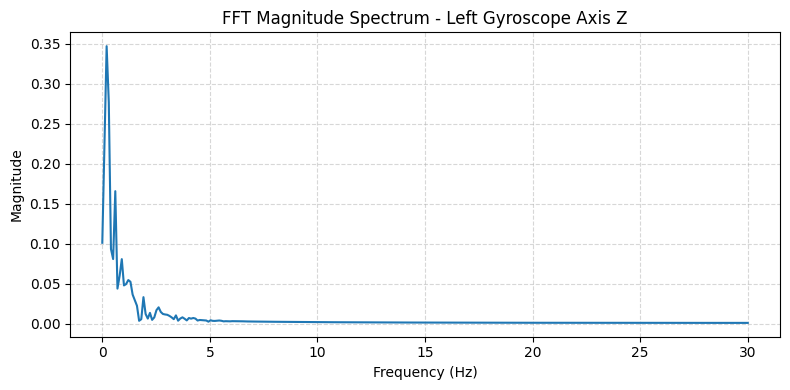

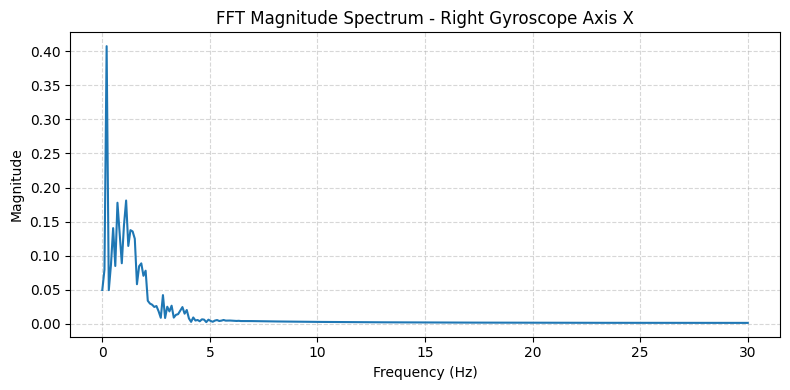

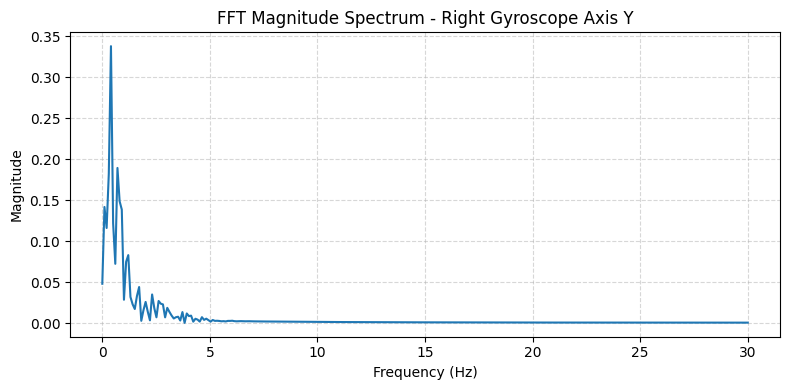

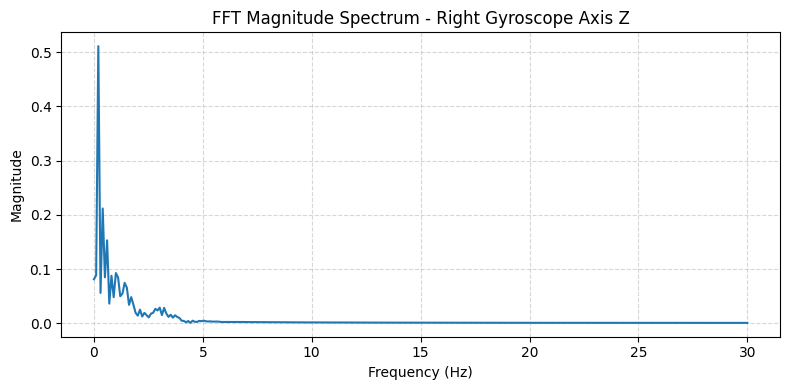

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_imu_fft(raw_imu_signals, sample_rate=60.0, sensor_label='IMU Sensor'):
    """
    Plot FFT magnitude spectrum for each axis of IMU signals.

    Args:
        raw_imu_signals: np.ndarray of shape (T, 3), where T is timesteps and 3 axes.
        sample_rate: Sampling frequency in Hz.
        sensor_label: Label for the sensor (e.g., 'Left Accelerometer').
    """
    T = raw_imu_signals.shape[0]
    # Compute FFT for each axis
    freqs = np.fft.rfftfreq(T, d=1.0 / sample_rate)  # frequencies
    fft_vals = np.fft.rfft(raw_imu_signals, axis=0)   # FFT values

    axes = ['X', 'Y', 'Z']
    for i in range(3):
        magnitude = np.abs(fft_vals[:, i]) / T  # normalize
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, magnitude)
        plt.title(f'FFT Magnitude Spectrum - {sensor_label} Axis {axes[i]}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Example usage with your raw data arrays:
plot_imu_fft(left_acc_filt,  sample_rate=60.0, sensor_label='Left Accelerometer')
plot_imu_fft(right_acc_filt, sample_rate=60.0, sensor_label='Right Accelerometer')
plot_imu_fft(left_gyro, sample_rate=60.0, sensor_label='Left Gyroscope')
plot_imu_fft(right_gyro, sample_rate=60.0, sensor_label='Right Gyroscope')


## Create PyTorch dataset

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import *
from losses import *

#### Get subjects

In [10]:
subjects = np.unique([f.split('_')[-2] for f in filenames])

print(f'Found subjects: {subjects}')

Found subjects: ['s1' 's10' 's2' 's3' 's4' 's5' 's6' 's7' 's8' 's9']


#### Split train/test using LOSO

In [11]:
np.random.seed(42) # For reproducibility
permutation = np.random.permutation(len(subjects))
train_subjects = subjects[permutation[:-1]]
test_subjects = subjects[permutation[-1:]]

print(f'Training on subjects: {train_subjects}')
print(f'Testing on subjects: {test_subjects}')

Training on subjects: ['s8' 's10' 's5' 's1' 's7' 's2' 's9' 's4' 's3']
Testing on subjects: ['s6']


#### Instantiate datasets

In [12]:
# train_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in train_subjects)])
# test_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)])

window_size = 60
window_shift = 15
train_dataset = IMUDataset([f for f in filenames if any(s == f.split('_')[-2] for s in train_subjects)], 
                           filter=False, 
                           window_size=window_size, 
                           window_shift=window_shift)
test_dataset = IMUDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)], 
                          filter=False, 
                          window_size=window_size, 
                          window_shift=window_shift)

#### Collate function to deal with different lengths

In [13]:
def collate_fn(batch):
    longest_sample = max(batch, key=lambda x: len(x['time']))
    max_len = len(longest_sample['time']) # max_len
    padded_batch = []

    for sample in batch:
        padding_len = max_len - len(sample['time'])
        padded_sample = {}
        padded_sample['mocap'] = torch.cat([sample['mocap'],
                                            sample['mocap'][-1:].repeat(padding_len,1,1)]) # (max_len, 8, 3)
        acc = torch.cat([sample['imu'][:,[0,1]],
                         sample['imu'][-1:,[0,1]].repeat(padding_len,1,1)]) # (max_len, 2, 3)
        gyro = torch.cat([sample['imu'][:,[2,3]],
                          torch.zeros_like(sample['imu'][-1:,[2,3]]).repeat(padding_len,1,1)]) # (max_len, 2, 3)
        padded_sample['imu'] = torch.cat([acc, gyro], dim=1) # (max_len, 4, 3)
        padded_batch.append(padded_sample)

    return {'time': longest_sample['time'],
            'mocap': torch.stack([sample['mocap'] for sample in padded_batch]),
            'imu': torch.stack([sample['imu'] for sample in padded_batch])}

#### Instantiate dataloaders

In [14]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

## Train model

#### Instantiate model

In [15]:
from model import *

# model = SimpleNN(input_size=4*3, hidden_size=8*3, num_layers=2) 

model = ConvTransformer(
    input_dim=12,
    transformer_dim=64,
    window_size=window_size,
    nhead=8,
    dim_feedforward=256,
    transformer_dropout=0.1,
    transformer_activation="gelu",
    num_encoder_layers=6,
    encode_position=True
)

# model = BiLSTM(input_size=12, hidden_size=12, num_layers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/patrick-do/Documents/Projects/CS690R_Project/cs690r/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ConvTransformer(
  (input_proj): Sequential(
    (0): Conv1d(12, 64, kernel_size=(1,), stride=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (3): GELU(approximate='none')
    (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (5): GELU(approximate='none')
    (6): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (7): GELU(approximate='none')
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  

#### Define criterion

In [16]:
criterion = nn.MSELoss()

#### Initialize optimizer

In [17]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Run epochs

In [18]:
num_epochs = 25

# ⭐ Define loss weights
angle_weight = 0.1
bone_length_weight = 0.2

# Create a dictionary to store metrics
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_mse': [],
    'test_mse': [],
    'train_angle': [],
    'test_angle': [],
    'train_bone': [],
    'test_bone': []
}

for epoch in range(num_epochs):
    print(f'Running epoch [{epoch+1}/{num_epochs}]')
    
    # Training loop
    model.train()
    epoch_train_loss = 0
    epoch_train_mse = 0
    epoch_train_angle = 0
    epoch_train_bone = 0
    
    for i, batch in enumerate(train_dataloader):
        # Move batch data onto device
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(batch['imu'])
        outputs_reshaped = outputs.view(*batch['mocap'].shape)
        
        # Calculate different loss components
        mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
        angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
        bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
        
        # ⭐ Combine losses
        total_loss = mse_loss + angle_loss + bone_loss
        # total_loss = mse_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_angle += angle_loss.item()
        epoch_train_bone += bone_loss.item()
        
        if (i+1) % 200 == 0:
            print(f'Train Step [{i+1}/{len(train_dataloader)}], Total Loss: {total_loss.item():.4f}, '
                  f'MSE: {mse_loss.item():.4f}, Angle: {angle_loss.item():.4f}, Bone: {bone_loss.item():.4f}')
    
    # Average losses for the epoch
    epoch_train_loss /= len(train_dataloader)
    epoch_train_mse /= len(train_dataloader)
    epoch_train_angle /= len(train_dataloader)
    epoch_train_bone /= len(train_dataloader)
    
    # Store metrics
    metrics['train_loss'].append(epoch_train_loss)
    metrics['train_mse'].append(epoch_train_mse)
    metrics['train_angle'].append(epoch_train_angle)
    metrics['train_bone'].append(epoch_train_bone)
    
    # Evaluation loop
    model.eval()
    epoch_test_loss = 0
    epoch_test_mse = 0
    epoch_test_angle = 0
    epoch_test_bone = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            #Move batch data onto device
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            # Forward pass
            outputs = model(batch['imu'])
            outputs_reshaped = outputs.view(*batch['mocap'].shape)
            
            # Calculate different loss components
            mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
            angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
            bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
            
            # Combine losses
            total_loss = mse_loss + angle_loss + bone_loss
            # total_loss = mse_loss
            
            # Accumulate losses
            epoch_test_loss += total_loss.item()
            epoch_test_mse += mse_loss.item()
            epoch_test_angle += angle_loss.item()
            epoch_test_bone += bone_loss.item()
            
            if (i+1) % 200 == 0:
                print(f'Test Step [{i+1}/{len(test_dataloader)}], Total Loss: {total_loss.item():.4f}, '
                      f'MSE: {mse_loss.item():.4f}, Angle: {angle_loss.item():.4f}, Bone: {bone_loss.item():.4f}')
    
    # Average losses for the epoch
    epoch_test_loss /= len(test_dataloader)
    epoch_test_mse /= len(test_dataloader)
    epoch_test_angle /= len(test_dataloader)
    epoch_test_bone /= len(test_dataloader)
    
    # Store metrics
    metrics['test_loss'].append(epoch_test_loss)
    metrics['test_mse'].append(epoch_test_mse)
    metrics['test_angle'].append(epoch_test_angle)
    metrics['test_bone'].append(epoch_test_bone)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    # Save model checkpoint if desired
    if epoch % 5 == 4:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
            'metrics': metrics
        }, f'checkpoint_epoch_{epoch}.pth')

Running epoch [1/25]
Train Step [200/2874], Total Loss: 0.0767, MSE: 0.0706, Angle: 0.0001, Bone: 0.0060
Train Step [400/2874], Total Loss: 0.0772, MSE: 0.0712, Angle: 0.0003, Bone: 0.0057
Train Step [600/2874], Total Loss: 0.0477, MSE: 0.0425, Angle: 0.0000, Bone: 0.0052
Train Step [800/2874], Total Loss: 0.0600, MSE: 0.0559, Angle: 0.0000, Bone: 0.0041
Train Step [1000/2874], Total Loss: 0.0498, MSE: 0.0455, Angle: 0.0002, Bone: 0.0041
Train Step [1200/2874], Total Loss: 0.0229, MSE: 0.0189, Angle: 0.0000, Bone: 0.0040
Train Step [1400/2874], Total Loss: 0.0307, MSE: 0.0277, Angle: 0.0000, Bone: 0.0030
Train Step [1600/2874], Total Loss: 0.0212, MSE: 0.0179, Angle: 0.0000, Bone: 0.0033
Train Step [1800/2874], Total Loss: 0.0396, MSE: 0.0370, Angle: 0.0000, Bone: 0.0025
Train Step [2000/2874], Total Loss: 0.0315, MSE: 0.0292, Angle: 0.0001, Bone: 0.0022
Train Step [2200/2874], Total Loss: 0.0342, MSE: 0.0318, Angle: 0.0002, Bone: 0.0023
Train Step [2400/2874], Total Loss: 0.0199, MSE:

### ⭐ Calculate MPJPE (Mean Per Joint Position Error) / MPVE (Mean Per Joint Velocity Error)
- Goal: MPJPE < 0.10~0.20 m (10–20cm), MPVE < ~1cm/s 

In [19]:
def compute_mpjpe(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPJPE (in meters)
    """
    error = torch.norm(predictions - targets, dim=-1)  # (B, T, J)
    return error.mean().item()

def compute_mpve(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPVE (in m/s)
    """
    pred_velocity = predictions[:, 1:, :, :] - predictions[:, :-1, :, :]  # (B, T-1, J, 3)
    target_velocity = targets[:, 1:, :, :] - targets[:, :-1, :, :]        # (B, T-1, J, 3)

    velocity_error = torch.norm(pred_velocity - target_velocity, dim=-1)  # (B, T-1, J)
    return velocity_error.mean().item()

In [20]:
# Evaluation loop
model.eval()

# Initialize accumulators
epoch_test_loss = 0
epoch_test_mse = 0
epoch_test_angle = 0
epoch_test_bone = 0
epoch_test_mpjpe = 0
epoch_test_mpve = 0

metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_mse': [],
    'test_mse': [],
    'train_angle': [],
    'test_angle': [],
    'train_bone': [],
    'test_bone': [],
     'test_mpjpe': [],  
    'test_mpve': []
}

with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        #Move batch data onto device
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}


        # Forward pass
        outputs = model(batch['imu'])  # Shape: (B, T*J*3)
        outputs_reshaped = outputs.view(*batch['mocap'].shape)  # (B, T, J, 3)

        # Loss components
        mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
        angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
        bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
        total_loss = mse_loss + angle_loss + bone_loss
        # total_loss = mse_loss

        # Accumulate losses
        epoch_test_loss += total_loss.item()
        epoch_test_mse += mse_loss.item()
        epoch_test_angle += angle_loss.item()
        epoch_test_bone += bone_loss.item()

        # ➕ Compute MPJPE and MPVE
        epoch_test_mpjpe += compute_mpjpe(outputs_reshaped, batch['mocap'])
        epoch_test_mpve += compute_mpve(outputs_reshaped, batch['mocap'])

        if (i + 1) % 10 == 0:
            print(f'Test Step [{i+1}/{len(test_dataloader)}], '
                  f'Total Loss: {total_loss.item():.4f}, '
                  f'MSE: {mse_loss.item():.4f}, '
                  f'Angle: {angle_loss.item():.4f}, '
                  f'Bone: {bone_loss.item():.4f}')

# Average over all batches
epoch_test_loss /= len(test_dataloader)
epoch_test_mse /= len(test_dataloader)
epoch_test_angle /= len(test_dataloader)
epoch_test_bone /= len(test_dataloader)
epoch_test_mpjpe /= len(test_dataloader)
epoch_test_mpve /= len(test_dataloader)

# Store metrics
metrics['test_loss'].append(epoch_test_loss)
metrics['test_mse'].append(epoch_test_mse)
metrics['test_angle'].append(epoch_test_angle)
metrics['test_bone'].append(epoch_test_bone)
metrics['test_mpjpe'].append(epoch_test_mpjpe)
metrics['test_mpve'].append(epoch_test_mpve)

# Summary
print(f'Epoch [{epoch+1}/{num_epochs}], '
      f'Test Loss: {epoch_test_loss:.4f}, '
      f'MSE: {epoch_test_mse:.4f} ',
      f'MPJPE: {epoch_test_mpjpe:.4f}, '
      f'MPVE: {epoch_test_mpve:.4f}')


Test Step [10/381], Total Loss: 0.0040, MSE: 0.0040, Angle: 0.0000, Bone: 0.0000
Test Step [20/381], Total Loss: 0.0230, MSE: 0.0230, Angle: 0.0000, Bone: 0.0000
Test Step [30/381], Total Loss: 0.0061, MSE: 0.0061, Angle: 0.0000, Bone: 0.0000
Test Step [40/381], Total Loss: 0.0081, MSE: 0.0081, Angle: 0.0000, Bone: 0.0000
Test Step [50/381], Total Loss: 0.0027, MSE: 0.0027, Angle: 0.0000, Bone: 0.0000
Test Step [60/381], Total Loss: 0.0043, MSE: 0.0043, Angle: 0.0000, Bone: 0.0000
Test Step [70/381], Total Loss: 0.0109, MSE: 0.0108, Angle: 0.0000, Bone: 0.0000
Test Step [80/381], Total Loss: 0.0047, MSE: 0.0047, Angle: 0.0000, Bone: 0.0000
Test Step [90/381], Total Loss: 0.0044, MSE: 0.0044, Angle: 0.0000, Bone: 0.0000
Test Step [100/381], Total Loss: 0.0038, MSE: 0.0037, Angle: 0.0000, Bone: 0.0000
Test Step [110/381], Total Loss: 0.0036, MSE: 0.0036, Angle: 0.0000, Bone: 0.0000
Test Step [120/381], Total Loss: 0.0037, MSE: 0.0037, Angle: 0.0000, Bone: 0.0000
Test Step [130/381], Tota

### ⭐ Evaluate Model performance

In [21]:
# after outputs_reshaped is computed
mpjpe = compute_mpjpe(outputs_reshaped, batch['mocap'])
mpve = compute_mpve(outputs_reshaped, batch['mocap'])

epoch_test_mpjpe += mpjpe
epoch_test_mpve += mpve

print(epoch_test_mpjpe)
print(epoch_test_mpve)

0.15666235250046873
0.004785756478324445


### ⭐ Visualize a result

In [22]:
from utils import visualize_model_predictions

# Call the visualization function after training
visualize_model_predictions(model, test_dataloader)

Saved figure for sample 1 at frame 0
Saved figure for sample 1 at frame 59


### 3D Skeleton Animation with Ground Truth vs Prediction

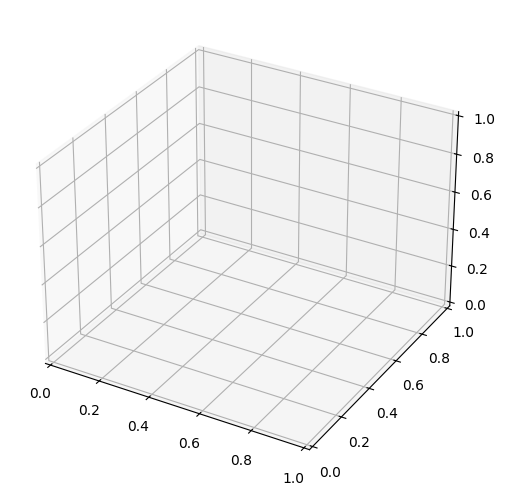

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

# If pred/gt are torch tensors, convert to numpy
pred = outputs_reshaped[0].detach().cpu().numpy()  # shape: (T, 8, 3)
gt = batch['mocap'][0].detach().cpu().numpy()      # shape: (T, 8, 3)
T = pred.shape[0]

# Joint connection pairs (for stick figure)
# Each tuple connects 2 joints by index. Adjust as needed.
connections = [(0, 1), (1, 2), (2, 3),  # left arm
               (4, 5), (5, 6), (6, 7)]  # right arm

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()  # Clear the previous frame

    # Plot predicted joints
    pred_joints = pred[frame]
    gt_joints = gt[frame]

    for i, j in connections:
        ax.plot(*zip(pred_joints[i], pred_joints[j]), color='r', linewidth=2, label='Predicted' if i == 0 else "")
        ax.plot(*zip(gt_joints[i], gt_joints[j]), color='g', linestyle='--', linewidth=2, label='Ground Truth' if i == 0 else "")

    ax.scatter(pred_joints[:, 0], pred_joints[:, 1], pred_joints[:, 2], color='r')
    ax.scatter(gt_joints[:, 0], gt_joints[:, 1], gt_joints[:, 2], color='g', marker='^')

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f'Frame {frame}')
    ax.legend(loc='best')
    ax.view_init(elev=20, azim=120)  # Adjust view angle

ani = FuncAnimation(fig, update, frames=T, interval=100)
plt.tight_layout()
plt.show()
